In [81]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util as len_plot_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
        
array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util
from mejiro.utils import util

In [82]:
ps_dir = os.path.join(data_dir, 'output', 'power_spectra_parallelized')
r = np.load(os.path.join(ps_dir, 'r.npy'))

Get subhalo mass functions

In [83]:
wdm_realizations = util.unpickle_all(ps_dir, 'wdm_realization_', '.pkl')
mdm_realizations = util.unpickle_all(ps_dir, 'mdm_realization_', '.pkl')
sdm_realizations = util.unpickle_all(ps_dir, 'sdm_realization_', '.pkl')
cdm_realizations = util.unpickle_all(ps_dir, 'cdm_realization_', '.pkl')

def get_bins_mean_std(realizations, num_bins):
    count_list = []

    for realization in realizations:
        halo_masses = [halo.mass for halo in realization.halos]
        count, bins = np.histogram(halo_masses, bins=np.logspace(6, 11, num_bins))
        count_list.append(count)

    return bins[:-1], np.mean(count_list, axis=0), np.std(count_list, axis=0)

bins_wdm_shmf, mean_wdm_shmf, std_wdm_shmf = get_bins_mean_std(wdm_realizations, 20)
bins_mdm_shmf, mean_mdm_shmf, std_mdm_shmf = get_bins_mean_std(mdm_realizations, 20)
bins_sdm_shmf, mean_sdm_shmf, std_sdm_shmf = get_bins_mean_std(sdm_realizations, 20)
bins_cdm_shmf, mean_cdm_shmf, std_cdm_shmf = get_bins_mean_std(cdm_realizations, 20)

Get power spectra of convergence maps

In [84]:
kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))
kappa_ps_wdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_wdm_*.npy'))]
kappa_ps_mdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_mdm_*.npy'))]
kappa_ps_sdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_sdm_*.npy'))]
kappa_ps_cdm = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_kappa_cdm_*.npy'))]

stack_kappa_ps_wdm = np.vstack(kappa_ps_wdm)
stack_kappa_ps_mdm = np.vstack(kappa_ps_mdm)
stack_kappa_ps_sdm = np.vstack(kappa_ps_sdm)
stack_kappa_ps_cdm = np.vstack(kappa_ps_cdm)

mean_kappa_ps_wdm = np.mean(stack_kappa_ps_wdm, axis=0)
mean_kappa_ps_mdm = np.mean(stack_kappa_ps_mdm, axis=0)
mean_kappa_ps_sdm = np.mean(stack_kappa_ps_sdm, axis=0)
mean_kappa_ps_cdm = np.mean(stack_kappa_ps_cdm, axis=0)

std_kappa_ps_wdm = np.std(stack_kappa_ps_wdm, axis=0, ddof=1)
std_kappa_ps_mdm = np.std(stack_kappa_ps_mdm, axis=0, ddof=1)
std_kappa_ps_sdm = np.std(stack_kappa_ps_sdm, axis=0, ddof=1)
std_kappa_ps_cdm = np.std(stack_kappa_ps_cdm, axis=0, ddof=1)

assert mean_kappa_ps_wdm.shape == kappa_r.shape == std_kappa_ps_wdm.shape == mean_kappa_ps_mdm.shape == std_kappa_ps_mdm.shape == mean_kappa_ps_cdm.shape == std_kappa_ps_cdm.shape == mean_kappa_ps_sdm.shape == std_kappa_ps_sdm.shape

Grab all data where we vary subhalo populations

In [85]:
res_wdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_wdm_*.npy'))]
res_mdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_mdm_*.npy'))]
res_sdm_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_sdm_*.npy'))]

mean_wdm = np.mean(res_wdm_list, axis=0)
mean_mdm = np.mean(res_mdm_list, axis=0)
mean_sdm = np.mean(res_sdm_list, axis=0)

# TODO make percentile instead of std because doesn't reflect asymmetry of distribution? but unclear what percentile would mean in this context
std_wdm = np.std(res_wdm_list, axis=0, ddof=1)
std_mdm = np.std(res_mdm_list, axis=0, ddof=1)
std_sdm = np.std(res_sdm_list, axis=0, ddof=1)

assert mean_wdm.shape == mean_mdm.shape == std_wdm.shape == std_mdm.shape == r.shape == mean_sdm.shape == std_sdm.shape

Grab all data where we vary detector positions

In [86]:
res_pos_1_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_1_*.npy'))]
res_pos_2_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_2_*.npy'))]
res_pos_3_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_3_*.npy'))]
res_pos_4_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_4_*.npy'))]
res_pos_5_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_5_*.npy'))]
res_pos_6_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_6_*.npy'))]
res_pos_7_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_7_*.npy'))]
res_pos_8_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_8_*.npy'))]
res_pos_9_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_9_*.npy'))]
res_pos_10_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_10_*.npy'))]
res_pos_11_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_11_*.npy'))]
res_pos_12_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_12_*.npy'))]
res_pos_13_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_13_*.npy'))]
res_pos_14_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_14_*.npy'))]
res_pos_15_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_15_*.npy'))]
res_pos_16_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_16_*.npy'))]
res_pos_17_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_17_*.npy'))]
res_pos_18_list = [np.load(i) for i in glob(os.path.join(ps_dir, f'res_ps_pos_18_*.npy'))]

mean_pos_1 = np.mean(res_pos_1_list, axis=0)
mean_pos_2 = np.mean(res_pos_2_list, axis=0)
mean_pos_3 = np.mean(res_pos_3_list, axis=0)
mean_pos_4 = np.mean(res_pos_4_list, axis=0)
mean_pos_5 = np.mean(res_pos_5_list, axis=0)
mean_pos_6 = np.mean(res_pos_6_list, axis=0)
mean_pos_7 = np.mean(res_pos_7_list, axis=0)
mean_pos_8 = np.mean(res_pos_8_list, axis=0)
mean_pos_9 = np.mean(res_pos_9_list, axis=0)
mean_pos_10 = np.mean(res_pos_10_list, axis=0)
mean_pos_11 = np.mean(res_pos_11_list, axis=0)
mean_pos_12 = np.mean(res_pos_12_list, axis=0)
mean_pos_13 = np.mean(res_pos_13_list, axis=0)
mean_pos_14 = np.mean(res_pos_14_list, axis=0)
mean_pos_15 = np.mean(res_pos_15_list, axis=0)
mean_pos_16 = np.mean(res_pos_16_list, axis=0)
mean_pos_17 = np.mean(res_pos_17_list, axis=0)
mean_pos_18 = np.mean(res_pos_18_list, axis=0)

std_pos_1 = np.std(res_pos_1_list, axis=0, ddof=1)
std_pos_2 = np.std(res_pos_2_list, axis=0, ddof=1)
std_pos_3 = np.std(res_pos_3_list, axis=0, ddof=1)
std_pos_4 = np.std(res_pos_4_list, axis=0, ddof=1)
std_pos_5 = np.std(res_pos_5_list, axis=0, ddof=1)
std_pos_6 = np.std(res_pos_6_list, axis=0, ddof=1)
std_pos_7 = np.std(res_pos_7_list, axis=0, ddof=1)
std_pos_8 = np.std(res_pos_8_list, axis=0, ddof=1)
std_pos_9 = np.std(res_pos_9_list, axis=0, ddof=1)
std_pos_10 = np.std(res_pos_10_list, axis=0, ddof=1)
std_pos_11 = np.std(res_pos_11_list, axis=0, ddof=1)
std_pos_12 = np.std(res_pos_12_list, axis=0, ddof=1)
std_pos_13 = np.std(res_pos_13_list, axis=0, ddof=1)
std_pos_14 = np.std(res_pos_14_list, axis=0, ddof=1)
std_pos_15 = np.std(res_pos_15_list, axis=0, ddof=1)
std_pos_16 = np.std(res_pos_16_list, axis=0, ddof=1)
std_pos_17 = np.std(res_pos_17_list, axis=0, ddof=1)
std_pos_18 = np.std(res_pos_18_list, axis=0, ddof=1)

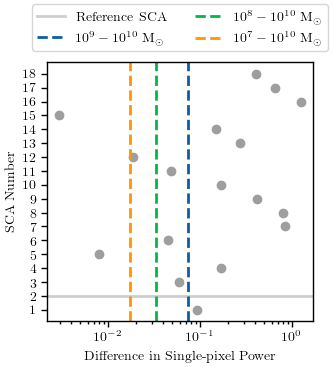

In [87]:
deviation_at_single_pixel = np.abs([mean[0] for mean in [mean_pos_1, mean_pos_2, mean_pos_3, mean_pos_4, mean_pos_5, mean_pos_6, mean_pos_7, mean_pos_8, mean_pos_9, mean_pos_10, mean_pos_11, mean_pos_12, mean_pos_13, mean_pos_14, mean_pos_15, mean_pos_16, mean_pos_17, mean_pos_18]])

wdm_deviation = np.abs(mean_wdm[0])
mdm_deviation = np.abs(mean_mdm[0])
sdm_deviation = np.abs(mean_sdm[0])

plt.figure(figsize=(3.5, 4))
plt.scatter(deviation_at_single_pixel, [f'{i}' for i in range(1, 19)], color='C6')
plt.axhline(1, color='C6', alpha=0.5, label='Reference SCA')
plt.axvline(wdm_deviation, color='C0', linestyle='--', label=r'$10^{9}-10^{10}$ M$_{\odot}$')
plt.axvline(mdm_deviation, color='C1', linestyle='--', label=r'$10^{8}-10^{10}$ M$_{\odot}$')
plt.axvline(sdm_deviation, color='C2', linestyle='--', label=r'$10^{7}-10^{10}$ M$_{\odot}$')
plt.ylabel('SCA Number')
plt.xlabel('Difference in Single-pixel Power')  # r'($|\bar{P} - \bar{P}_\textrm{SCA02}|$)'
plt.xscale('log')
plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'power_spectra_scas.png'))
plt.show()

Plot

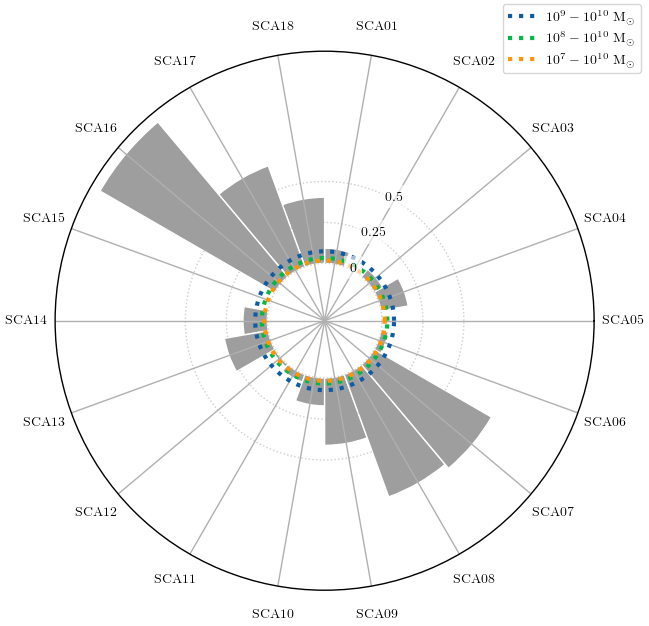

In [88]:
f = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
# ax.set_rscale('asinh')

inner_radius = 0.35
width = 2 * np.pi / 18
indices = list(range(1, 19))
angles = [element * width for element in indices]

# test = np.linspace(0, 100, 18)
# print(test)
# test = np.roll(test, 14)
# test = np.flip(test)
# print(test)

deviation_at_single_pixel = np.abs([mean[0] for mean in [mean_pos_1, mean_pos_2, mean_pos_3, mean_pos_4, mean_pos_5, mean_pos_6, mean_pos_7, mean_pos_8, mean_pos_9, mean_pos_10, mean_pos_11, mean_pos_12, mean_pos_13, mean_pos_14, mean_pos_15, mean_pos_16, mean_pos_17, mean_pos_18]])
deviation_at_single_pixel = np.flip(np.roll(deviation_at_single_pixel, 14))
labels = [f'SCA{str(i).zfill(2)}' for i in range(1, 19)]
labels = np.flip(np.roll(labels, 13))

bars = ax.bar(x=angles, height=deviation_at_single_pixel, width=width, bottom=inner_radius, edgecolor='white', color='C6')
ax.plot(np.linspace(0, 2 * np.pi, 100), [wdm_deviation + inner_radius] * 100, color='C0', linewidth=3., linestyle=':', label=r'$10^{9}-10^{10}$ M$_{\odot}$')
ax.plot(np.linspace(0, 2 * np.pi, 100), [mdm_deviation + inner_radius] * 100, color='C1', linewidth=3., linestyle=':', label=r'$10^{8}-10^{10}$ M$_{\odot}$')
ax.plot(np.linspace(0, 2 * np.pi, 100), [sdm_deviation + inner_radius] * 100, color='C2', linewidth=3., linestyle=':', label=r'$10^{7}-10^{10}$ M$_{\odot}$')

# custom radial grid lines
angle = 1.05
for i in [0, 2.5e-1, 5e-1]:
    ax.plot(np.linspace(0, 2 * np.pi, 100), [i + inner_radius] * 100, color='C6', linewidth=1., alpha=0.5, linestyle=':')
    t = ax.text(angle, i + inner_radius, s=f'{i}', ha='center')
    t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none'))
# for i in np.linspace(1e-2, 1e-1, 10):
#     ax.plot(np.linspace(0, 2 * np.pi, 100), [i + inner_radius] * 100, color='C6', linewidth=1., alpha=0.5, linestyle=':')
#     ax.text(angle, i + inner_radius, s=f'{i:.2f}', ha='center')
# t = ax.text(angle, 2.4e-1 + inner_radius, s=r'$P-P_\textrm{SCA02}$', ha='center')
# t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))

x_ticks = np.linspace(0, 2 * np.pi, 18, endpoint=False)
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', which='major', pad=10)  # pushes labels away from the center
# ax.set_rgrids([1, 2, 3, 4, 5], angle=angles[2] * 180 / np.pi)

ax.set_yticks([])

plt.legend(loc='best', bbox_to_anchor=(0.6, 0.6, 0.5, 0.5))
plt.savefig(os.path.join(figure_dir, 'power_spectra_polar.png'), dpi=1200)
plt.show()

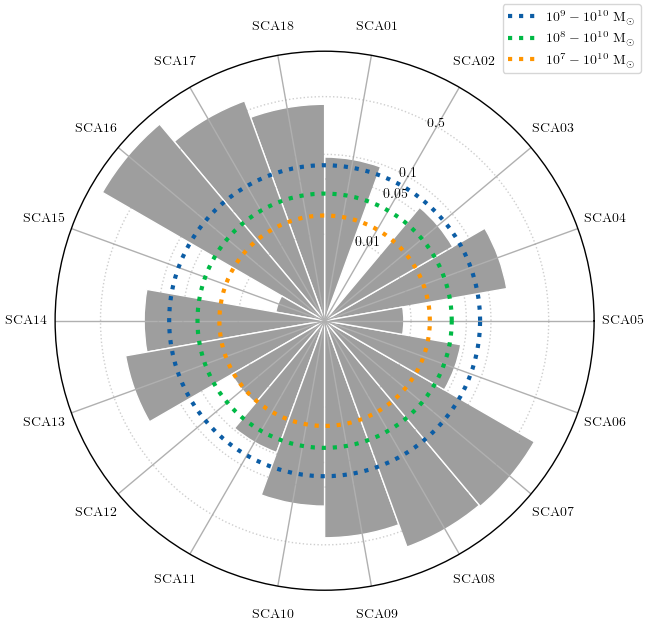

In [89]:
f = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.set_rscale('log')

inner_radius = 0.001
width = 2 * np.pi / 18
indices = list(range(1, 19))
angles = [element * width for element in indices]

# test = np.linspace(0, 100, 18)
# print(test)
# test = np.roll(test, 14)
# test = np.flip(test)
# print(test)

deviation_at_single_pixel = np.abs([mean[0] for mean in [mean_pos_1, mean_pos_2, mean_pos_3, mean_pos_4, mean_pos_5, mean_pos_6, mean_pos_7, mean_pos_8, mean_pos_9, mean_pos_10, mean_pos_11, mean_pos_12, mean_pos_13, mean_pos_14, mean_pos_15, mean_pos_16, mean_pos_17, mean_pos_18]])
deviation_at_single_pixel = np.flip(np.roll(deviation_at_single_pixel, 14))
labels = [f'SCA{str(i).zfill(2)}' for i in range(1, 19)]
labels = np.flip(np.roll(labels, 13))

# pprint(deviation_at_single_pixel)

bars = ax.bar(x=angles, height=deviation_at_single_pixel, width=width, bottom=inner_radius, edgecolor='white', color='C6')
ax.plot(np.linspace(0, 2 * np.pi, 100), [wdm_deviation + inner_radius] * 100, color='C0', linewidth=3., linestyle=':', label=r'$10^{9}-10^{10}$ M$_{\odot}$')
ax.plot(np.linspace(0, 2 * np.pi, 100), [mdm_deviation + inner_radius] * 100, color='C1', linewidth=3., linestyle=':', label=r'$10^{8}-10^{10}$ M$_{\odot}$')
ax.plot(np.linspace(0, 2 * np.pi, 100), [sdm_deviation + inner_radius] * 100, color='C2', linewidth=3., linestyle=':', label=r'$10^{7}-10^{10}$ M$_{\odot}$')

# custom radial grid lines
angle = 1.05
for i in [1e-2, 5e-2, 1e-1, 5e-1]:
    ax.plot(np.linspace(0, 2 * np.pi, 100), [i + inner_radius] * 100, color='C6', linewidth=1., alpha=0.5, linestyle=':')
    t = ax.text(angle, i + inner_radius, s=f'{i}', ha='center')
    t.set_bbox(dict(facecolor='white', alpha=0., edgecolor='none'))
# for i in np.linspace(1e-2, 1e-1, 10):
#     ax.plot(np.linspace(0, 2 * np.pi, 100), [i + inner_radius] * 100, color='C6', linewidth=1., alpha=0.5, linestyle=':')
#     ax.text(angle, i + inner_radius, s=f'{i:.2f}', ha='center')
# t = ax.text(angle, 2.4e-1 + inner_radius, s=r'$P-P_\textrm{SCA02}$', ha='center')
# t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))

x_ticks = np.linspace(0, 2 * np.pi, 18, endpoint=False)
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', which='major', pad=10)  # pushes labels away from the center
# ax.set_rgrids([1, 2, 3, 4, 5], angle=angles[2] * 180 / np.pi)

ax.set_yticks([])

plt.legend(loc='best', bbox_to_anchor=(0.6, 0.6, 0.5, 0.5))
plt.savefig(os.path.join(figure_dir, 'power_spectra_polar.png'), dpi=1200)
plt.show()